In [248]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans
import numpy as np

In [211]:
spotify_data = pd.read_csv("Spotify_Dataset_V3.csv", delimiter=";")

#inspect df 
spotify_data.head(5)

,Rank,Title,Artists,Date,Danceability,Energy,Loudness,Speechiness,Acousticness,Instrumentalness,Valence,# of Artist,Artist (Ind.),# of Nationality,Nationality,Continent,Points (Total),Points (Ind for each Artist/Nat),id,Song URL
0,1,Ella Baila Sola,"Eslabon Armado, Peso Pluma",29/05/2023,0.668,0.758,-5176.0,0.033,0.483,0.000,0.834,Artist 1,Eslabon Armado,Nationality 1,Mexico,Latin-America,200,100.0,3qQbCzHBycnDpGskqOWY0E,https://open.spotify.com/track/3qQbCzHBycnDpGs...
1,1,Ella Baila Sola,"Eslabon Armado, Peso Pluma",29/05/2023,0.668,0.758,-5176.0,0.033,0.483,0.000,0.834,Artist 2,Peso Pluma,Nationality 2,Mexico,Latin-America,200,100.0,3qQbCzHBycnDpGskqOWY0E,https://open.spotify.com/track/3qQbCzHBycnDpGs...
2,2,WHERE SHE GOES,Bad Bunny,29/05/2023,0.652,0.800,-4019.0,0.061,0.143,0.629,0.234,Artist 1,Bad Bunny,Nationality 1,Puerto Rico,Latin-America,199,199.0,7ro0hRteUMfnOioTFI5TG1,https://open.spotify.com/track/7ro0hRteUMfnOio...
3,3,La Bebe - Remix,"Yng Lvcas, Peso Pluma",29/05/2023,0.812,0.479,-5678.0,0.333,0.213,0.000,0.559,Artist 1,Yng Lvcas,Nationality 1,Mexico,Latin-America,198,99.0,2UW7JaomAMuX9pZrjVpHAU,https://open.spotify.com/track/2UW7JaomAMuX9pZ...
4,3,La Bebe - Remix,"Yng Lvcas, Peso Pluma",29/05/2023,0.812,0.479,-5678.0,0.333,0.213,0.000,0.559,Artist 2,Peso Pluma,Nationality 2,Mexico,Latin-America,198,99.0,2UW7JaomAMuX9pZrjVpHAU,https://open.spotify.com/track/2UW7JaomAMuX9pZ...


In [212]:
df = spotify_data.sample(1000, random_state=42).reset_index(drop=True)
#bc file is too large 

#check for na 
missing_values = df.isna().sum()
missing_values

Rank                                0
Title                               0
Artists                             0
Date                                0
Danceability                        0
Energy                              0
Loudness                            0
Speechiness                         0
Acousticness                        0
Instrumentalness                    0
Valence                             0
# of Artist                         0
Artist (Ind.)                       0
# of Nationality                    0
Nationality                         0
Continent                           0
Points (Total)                      0
Points (Ind for each Artist/Nat)    0
id                                  0
Song URL                            0
dtype: int64

In [213]:

df.info()
print(df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 20 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Rank                              1000 non-null   int64  
 1   Title                             1000 non-null   object 
 2   Artists                           1000 non-null   object 
 3   Date                              1000 non-null   object 
 4   Danceability                      1000 non-null   float64
 5   Energy                            1000 non-null   float64
 6   Loudness                          1000 non-null   float64
 7   Speechiness                       1000 non-null   float64
 8   Acousticness                      1000 non-null   float64
 9   Instrumentalness                  1000 non-null   float64
 10  Valence                           1000 non-null   float64
 11  # of Artist                       1000 non-null   object 
 12  Artist 

In [214]:
#create graph 
G = nx.Graph()

for _, row in df.iterrows():
    # filter for only latin american songs
    if row["Continent"] == "Latin-America":
        #split mult artists in a song
        artists = [a.strip() for a in row["Artists"].split(",")]

     # add edges between all artists in the same song
        for i in range(len(artists)):
            for j in range(i+ 1, len(artists)):
                if G.has_edge(artists[i], artists[j]):
                    G[artists[i]][artists[j]]["weight"] += 1
                else:
                    G.add_edge(artists[i], artists[j], weight=1)

In [215]:
#centrality metrics
degree = nx.degree_centrality(G)
eigenvector = nx.eigenvector_centrality(G, max_iter=500)

#create df 
centrality_df = pd.DataFrame({"Artist": list(degree.keys()), "Degree Centrality": list(degree.values()),
                              "Eigenvector Centrality": list(eigenvector.values())})

In [216]:
#soring by centrality 
top_artists = centrality_df.sort_values("Eigenvector Centrality", ascending=False).head(10)
print("Top 10 Most Central Artists:")
print(top_artists, "\n")

Top 10 Most Central Artists:
           Artist  Degree Centrality  Eigenvector Centrality
22      Nicky Jam           0.156627                0.293484
24           Sech           0.150602                0.281465
6       Bad Bunny           0.186747                0.242808
47          Ozuna           0.126506                0.236862
9        J Balvin           0.174699                0.230606
13        Farruko           0.120482                0.229763
1        Anuel AA           0.126506                0.217441
25  Lenny Tavárez           0.120482                0.201458
21          Dalex           0.120482                0.201458
23  Justin Quiles           0.108434                0.192348 



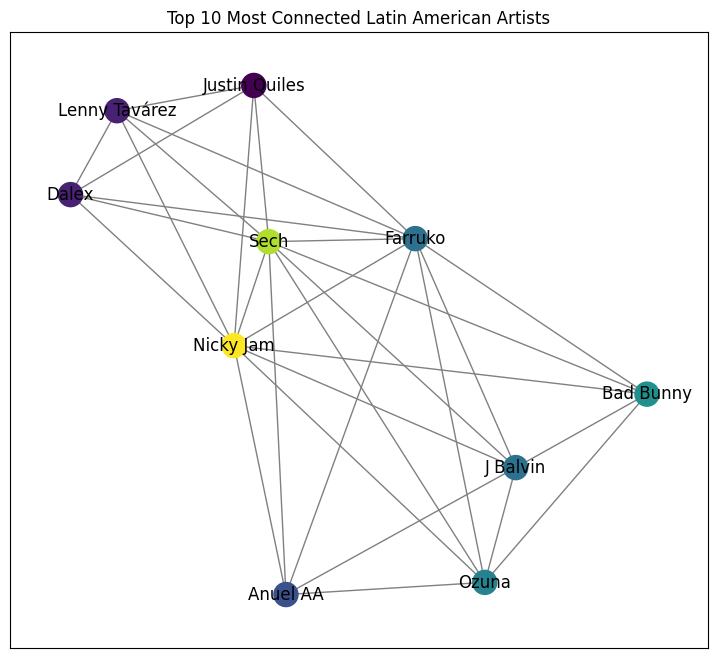

In [217]:
#top 10, gets too cluttered otherwise
top_nodes = sorted(degree, key=degree.get, reverse=True)[:10]
subgraph = G.subgraph(top_nodes)

#plotting 

plt.figure(figsize=(9, 8))
pos = nx.spring_layout(subgraph, k=0.5, seed=42)
node_color = [eigenvector[node] for node in subgraph.nodes()]

nx.draw_networkx(subgraph, pos,with_labels=True,node_color=node_color,  edge_color="gray")
plt.title("Top 10 Most Connected Latin American Artists")
plt.show()

# Clustering

### Add Degree and Eigenvector Centrality to the dataset

In [219]:
deg_dict = dict(zip(centrality_df["Artist"],centrality_df["Degree Centrality"]))
eig_dict = dict(zip(centrality_df["Artist"],centrality_df["Eigenvector Centrality"]))

In [239]:
df_la = df.copy()
df_la = df_la[df_la["Continent"]=="Latin-America"]
df_focus = df_la[["Rank"]]

In [240]:
print("missing values in degree centrality:",centrality_df["Degree Centrality"].isna().any())
print("missing values in eigenvector centrality:",centrality_df["Eigenvector Centrality"].isna().any())
print("missing values in rank:", df_focus["Rank"].isna().any())

# All outputs are false - continue

missing values in degree centrality: False
missing values in eigenvector centrality: False
missing values in rank: False


In [242]:
all_deg_lists = []
all_eig_lists = []

for _, row in df_la.iterrows():
    artist_row = row["Artists"]
    # each row contains a list of artists
    artist_list = artist_row.split(",")
    deg_list = []
    eig_list = []

    for artist in artist_list:
        artist = artist.strip()
        deg_list.append(deg_dict.get(artist,None))
        eig_list.append(eig_dict.get(artist,None))
    
    all_deg_lists.append(deg_list)
    all_eig_lists.append(eig_list)


In [243]:
# iterate through all of the degree lists and take each deg_list average
avg_deg_list = []
avg_eig_list = []
rows_kept = []
# iterate through each individual deg_list in all_deg_lists
for i, (deg_list, eig_list) in enumerate(zip(all_deg_lists, all_eig_lists)):
    # skip row if any missing degree centralities
    if None in deg_list or None in eig_list:
        continue
    avg_deg_list.append(sum(deg_list) / len(deg_list))
    avg_eig_list.append(sum(eig_list) / len(eig_list))
    # indices of rows to keep
    rows_kept.append(i)

In [244]:
df_focus = df_focus.iloc[rows_kept].copy()
df_focus["Average Degree Centrality"] = avg_deg_list
df_focus["Average Eigenvector Centrality"] = avg_eig_list

Validation

In [245]:
# Check some values in the Average Degree Centrality column.
# The artists of La Jeepeta - Remix have an average degree centrality of 0.071084.
df_focus

,Rank,Average Degree Centrality,Average Eigenvector Centrality
9,120,0.071084,1.077932e-01
25,108,0.070281,9.392649e-02
26,146,0.124498,1.695280e-01
37,73,0.064759,1.154516e-01
46,118,0.106426,1.692260e-01
...,...,...,...
955,169,0.030120,1.443891e-02
956,46,0.006024,6.701597e-18
957,11,0.099398,1.311468e-01
984,166,0.077108,1.349842e-01


In [ ]:
# Find all of the artists for La Jeepeta - Remix in deg_dict and manually calculate the average to see if it matches.
deg_dict

# This should be done for a few rows as well as both centralities.
# To look at each artist's Eigenvector centrality, recall the variable is eig_dict

{'Nio Garcia': 0.08433734939759037,
 'Anuel AA': 0.12650602409638556,
 'Myke Towers': 0.0963855421686747,
 'Brray': 0.024096385542168676,
 'Juanka': 0.024096385542168676,
 'Tainy': 0.012048192771084338,
 'Bad Bunny': 0.18674698795180725,
 'Julieta Venegas': 0.012048192771084338,
 'Cardi B': 0.012048192771084338,
 'J Balvin': 0.1746987951807229,
 'Chris Jedi': 0.03614457831325302,
 'Chencho Corleone': 0.06626506024096386,
 'Ñengo Flow': 0.030120481927710843,
 'Farruko': 0.12048192771084337,
 'Rvssian': 0.012048192771084338,
 'Paulo Pires': 0.012048192771084338,
 'Mc Danny': 0.012048192771084338,
 'Marcynho Sensação': 0.012048192771084338,
 'Luis Fonsi': 0.01807228915662651,
 'Daddy Yankee': 0.10240963855421688,
 'Justin Bieber': 0.012048192771084338,
 'Dalex': 0.12048192771084337,
 'Nicky Jam': 0.1566265060240964,
 'Justin Quiles': 0.10843373493975904,
 'Sech': 0.15060240963855423,
 'Lenny Tavárez': 0.12048192771084337,
 'Feid': 0.0963855421686747,
 'Rafa Pabön': 0.04819277108433735,
 '

### Selecting the K-Value

In [246]:
inertia_vals = []

for test_k in range(2,31):
    print("test k: ", test_k)

    test_k_model = MiniBatchKMeans(
        n_clusters=test_k,
        n_init=15,
        max_iter=500,
        tol=0.5,
        reassignment_ratio=0.5,
        random_state=42
    )

    test_k_model.fit(df_focus)

    inertia = test_k_model.inertia_

    # store to plot later
    inertia_vals.append((test_k,inertia))

inertia_df = pd.DataFrame(inertia_vals, columns=["k", "inertia"])

test k:  2
test k:  3
test k:  4
test k:  5
test k:  6
test k:  7
test k:  8
test k:  9
test k:  10
test k:  11
test k:  12
test k:  13
test k:  14
test k:  15
test k:  16
test k:  17
test k:  18
test k:  19
test k:  20
test k:  21
test k:  22
test k:  23
test k:  24
test k:  25
test k:  26
test k:  27
test k:  28
test k:  29
test k:  30


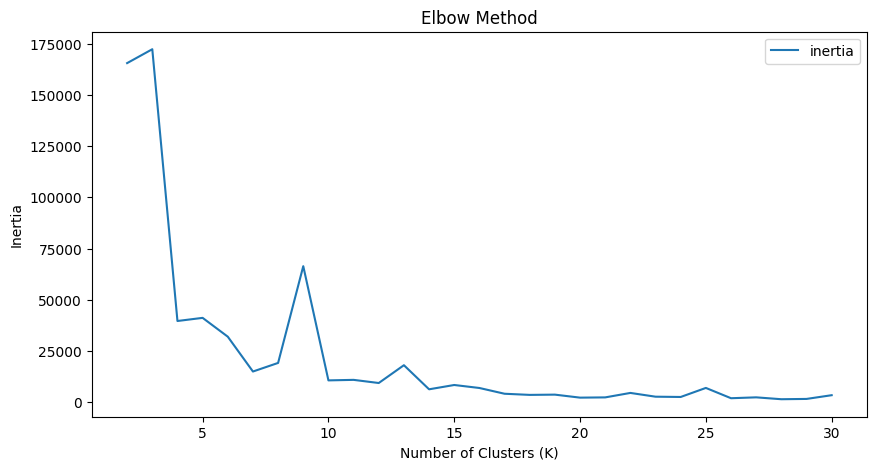

In [247]:
fig,ax = plt.subplots(figsize=(10,5))
inertia_df.plot("k", "inertia",ax=ax)
ax.set_xlabel("Number of Clusters (K)")
ax.set_ylabel("Inertia")
ax.set_title("Elbow Method")
plt.show()

### Clustering

In [249]:
df_focus.index

Index([  9,  25,  26,  37,  46,  47,  50,  55,  62,  70,
       ...
       921, 931, 940, 948, 949, 955, 956, 957, 984, 989],
      dtype='int64', length=203)

In [254]:
clustering = MiniBatchKMeans(
    n_clusters=7,
    n_init=15,
    max_iter=500,
    tol=0.5,
    reassignment_ratio=0.5,
    random_state=42
)

cluster_labels = clustering.fit_predict(df_focus)

cluster_df = pd.DataFrame({"Cluster": cluster_labels}, index=df_focus.index)

rand_num_gen = np.random.default_rng(42)

# cluster labels and clusters
for cluster_id, cluster in cluster_df.groupby("Cluster"):
    print(f"Cluster {cluster_id}")
    # if there are less than five in a cluster just print the amount of rows in that cluster
    if len(cluster) < 5:
        to_print = len(cluster)
    else:
        to_print = 5
    
    sampled = rand_num_gen.choice(cluster.index.to_numpy(), size=to_print, replace=False)

    for id in sampled:
        row = df_focus.loc[id]
        rank = row["Rank"]
        deg = row["Average Degree Centrality"]
        eig = row["Average Eigenvector Centrality"]
        print(f"ID: {id}\n Rank: {rank}\n Average Degree Centrality: {deg}\n Average Eigenvector Centrality: {eig}")

Cluster 0
ID: 721
 Rank: 117.0
 Average Degree Centrality: 0.0783132530120482
 Average Eigenvector Centrality: 0.11846122564812483
ID: 479
 Rank: 111.0
 Average Degree Centrality: 0.015060240963855423
 Average Eigenvector Centrality: 0.0014428503917428709
ID: 584
 Rank: 121.0
 Average Degree Centrality: 0.05903614457831326
 Average Eigenvector Centrality: 0.10263898275270089
ID: 76
 Rank: 108.0
 Average Degree Centrality: 0.024096385542168676
 Average Eigenvector Centrality: 0.01961370900028756
ID: 989
 Rank: 115.0
 Average Degree Centrality: 0.11566265060240966
 Average Eigenvector Centrality: 0.17863821239716696
Cluster 1
ID: 820
 Rank: 28.0
 Average Degree Centrality: 0.11927710843373496
 Average Eigenvector Centrality: 0.19397828372413617
ID: 104
 Rank: 40.0
 Average Degree Centrality: 0.18674698795180725
 Average Eigenvector Centrality: 0.24280759139633526
ID: 428
 Rank: 26.0
 Average Degree Centrality: 0.07028112449799197
 Average Eigenvector Centrality: 0.09392649442516939
ID: 7